# **Mapping and Perception for an autonomous robot (0510-7951)**

Roy orfaig and Professor Ben-Zion Bobrovsky

TAU 2023/B

#Exercise 3:
---
**ParticleFilter**

In this section you will implement the algorithm of Particle filter on simulated data and analyze the results.

Used your simualted based on your last nubmer of your ID number
for use your you should copy on to the worksapce of colab

Copy the odometry.dat file also to the colab workspace.


# Preparation

In [ ]:
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
from pandas.plotting import table
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
import os
import math
import itertools
import pandas as pd
import sys
sys.path.append('/content')
seed_val =19
np.random.seed(seed_val)

# Mount the Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_landmarks(filename):
    # Reads the world definition and returns a list of landmarks, our 'map'.
    # .
    # The returned dict contains a list of landmarks each with the
    # following information: {id, [x, y]}

    landmarks = []

    f = open(filename)

    for line in f:
        line_s = line.split('\n')
        line_spl = line_s[0].split(',')
        landmarks.append([float(line_spl[0]), float(line_spl[1])])

    return landmarks


def read_odometry(filename):
    # Reads the odometry and sensor readings from a file.
    #
    # The data is returned in a dict where the u_t and z_t are stored
    # together as follows:
    #
    # {odometry,sensor}
    #
    # where "odometry" has the fields r1, r2, t which contain the values of
    # the identically named motion model variables, and sensor is a list of
    # sensor readings with id, range, bearing as values.
    #
    # The odometry and sensor values are accessed as follows:
    # odometry_data = sensor_readings[timestep, 'odometry']
    # sensor_data = sensor_readings[timestep, 'sensor']

    sensor_readings = dict()

    first_time = True
    timestamp = 0
    f = open(filename)

    for line in f:

        line_s = line.split('\n')  # remove the new line character
        line_spl = line_s[0].split(' ')  # split the line

        if line_spl[0] == 'ODOMETRY':
            sensor_readings[timestamp] = {'r1': float(line_spl[1]), 't': float(line_spl[2]), 'r2': float(line_spl[3])}
            timestamp = timestamp + 1

    return sensor_readings

# Display the simulated data

### Load data

In [ ]:
 """ Load data """
print("Reading ground truth landmarks")
trueLandmarks = np.array(read_landmarks("/content/drive/MyDrive/Autonomous system/HW3/LastID_0.csv")) #TODO -load your map

print("Reading ground truth odometry")
trueOdometry = read_odometry("/content/drive/MyDrive/Autonomous system/HW3/odometry.dat")



Reading ground truth landmarks
Reading ground truth odometry


### Calculate true trajectory


In [ ]:
trueTrajectory = np.zeros((trueOdometry.__len__(), 3))
for i in range(1, trueOdometry.__len__()):
    dr1 = trueOdometry[i - 1]['r1']
    dt = trueOdometry[i - 1]['t']
    dr2 = trueOdometry[i - 1]['r2']
    theta = trueTrajectory[i - 1, 2]
    dMotion =  np.expand_dims(np.array([dt * math.cos(theta + dr1), dt * math.sin(theta + dr1), dr1 + dr2]), 0)  #TODO fill odometry model
    trueTrajectory[i, :] = trueTrajectory[i-1, :] + dMotion

### Plot the trajectory

Text(0.5, 1.0, 'Ground trues trajectory and landmarks')

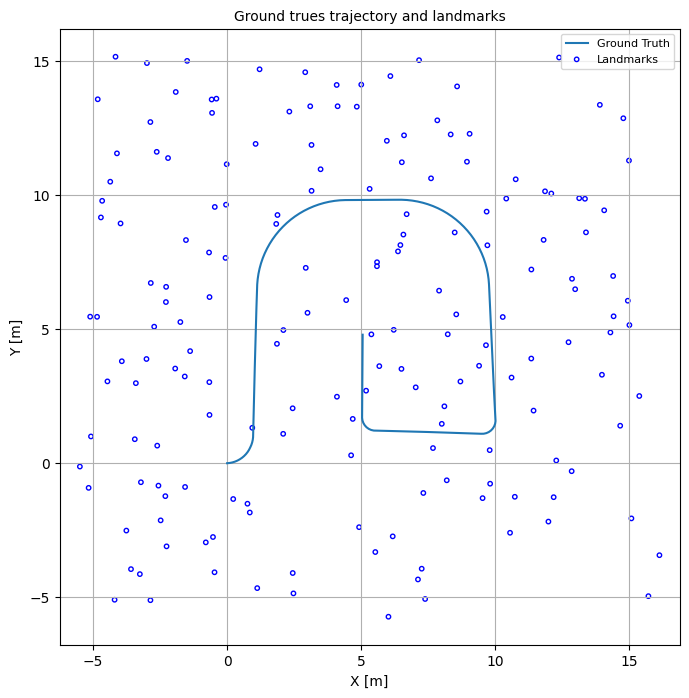

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(trueTrajectory[:, 0], trueTrajectory[:, 1])
plt.scatter(trueLandmarks[:, 0], trueLandmarks[:, 1], s=10, facecolors='none', edgecolors='b')
plt.grid()
plt.axis('equal')
plt.xlabel("X [m]", fontsize=10)
plt.ylabel("Y [m]", fontsize=10)
plt.legend(['Ground Truth', 'Landmarks'], prop={"size": 8}, loc="best")
plt.title('Ground trues trajectory and landmarks', fontsize=10)

### Generate measurement odometry

Text(0.5, 1.0, 'Ground trues trajectory, landmarks and noisy trajectory')

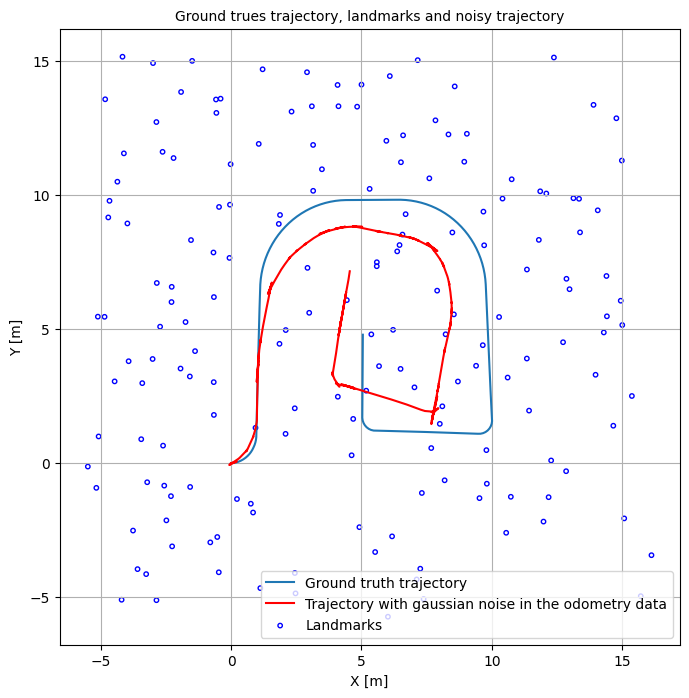

In [ ]:
np.random.seed(seed_val)
sigma_r1 = 0.01 #TODO
sigma_t = 0.2 #TODO
sigma_r2 = 0.01 #TODO
measurmentOdometry = dict()
measured_trajectory = np.zeros((trueOdometry.__len__() + 1, 3))
for i, timestamp in enumerate(range(trueOdometry.__len__())):
    dr1 = trueOdometry[timestamp]['r1'] + float(np.random.normal(0,  sigma_r1, 1))  #TODO fill gaussian noise parameter
    dt = trueOdometry[timestamp]['t'] + float(np.random.normal( 0,  sigma_t, 1))    #TODO fill gaussian noise parameter
    dr2 = trueOdometry[timestamp]['r2'] + float(np.random.normal(0,  sigma_r2, 1))  #TODO fill gaussian noise parameter
    measurmentOdometry[timestamp] = {'r1': dr1,
                                      't': dt,
                                      'r2': dr2}
    theta = measured_trajectory[i, 2]
    dMotion = np.expand_dims(np.array([dt * np.cos(theta + dr1), dt * np.sin(theta + dr1), dr1 + dr2]), 0)  #TODO fill odometry model
    measured_trajectory[i + 1, :] = measured_trajectory[i, :] + dMotion

plt.figure(figsize=(8, 8))
plt.plot(trueTrajectory[:, 0], trueTrajectory[:, 1])
plt.plot(measured_trajectory[:, 0], measured_trajectory[:, 1], color='r')
plt.scatter(trueLandmarks[:, 0], trueLandmarks[:, 1], s=10, facecolors='none', edgecolors='b')
plt.grid()
plt.xlabel("X [m]", fontsize=10)
plt.ylabel("Y [m]", fontsize=10)
plt.legend(['Ground truth trajectory', 'Trajectory with gaussian noise in the odometry data', 'Landmarks'], prop={"size": 10}, loc="best")
plt.title('Ground trues trajectory, landmarks and noisy trajectory', fontsize=10)

# Particle Filter core functions

In [ ]:
from numpy.linalg import linalg
np.random.seed(seed_val)
class ParticlesFilter:
    def __init__(self, worldLandmarks, sigma_r1, sigma_t, sigma_r2, sigma_range, sigma_bearing, numberOfPaticles=500):
        """
        Initialization of the particle filter
        """

        # Initialize parameters
        self.numberOfParticles = numberOfPaticles
        self.worldLandmarks = worldLandmarks

        self.sigma_r1 = sigma_r1
        self.sigma_t = sigma_t
        self.sigma_r2 = sigma_r2

        self.sigma_range = sigma_range
        self.sigma_bearing = sigma_bearing

        # Initialize particles - x, y, heading, weight (uniform weight for initialization)
        self.particles = np.concatenate((np.random.normal(0,2, (self.numberOfParticles, 1)),
                                         np.random.normal(0, 2, (self.numberOfParticles, 1)),
                                         ParticlesFilter.normalize_angles_array(np.random.normal(0.1, 0.1, (self.numberOfParticles, 1)))), axis=1)

        self.weights =  np.ones(self.numberOfParticles)* 1.0/self.numberOfParticles #TODO fill inital weights
        self.history = np.array((0, 0, 0.1)).reshape(1, 3)
        self.particles_history = np.expand_dims(self.particles.copy(), axis=0)

    def apply(self, Zt, Ut):
        """
        apply the particle filter on a single step in the sequence
        Parameters:
            Zt - the sensor measurement (range, bearing) as seen from the current position of the car
            Ut - the true odometry control command
        """
        #print('starting motion model')
        # Motion model based on odometry

        self.motionModel(Ut)
        #print('starting Measurement prediction')
        # Measurement prediction
        ParticlesLocation = self.MeasurementPrediction()
        #print('starting Sensor correction')
        # Sensor correction
        self.weightParticles(Zt, ParticlesLocation)

        self.history = np.concatenate((self.history, self.bestKParticles(1).reshape(1, 3)), axis=0)
        #print('Resample particles')
        # Resample particles
        self.resampleParticles()

        self.particles_history = np.concatenate((self.particles_history, np.expand_dims(self.particles.copy(), axis=0)), axis=0)

    def motionModel(self, odometry):
        """
        Apply the odometry motion model to the particles
        odometry - the true odometry control command
        the particles will be updated with the true odometry control command
        in addition, each particle will separately be added with Gaussian noise to its movement
        """
        ############################
        # HERE IS THE BUGGG ITS THE SHAPE
        #####################################
        mu=0
        dr1 =  odometry['r1'] + (np.random.normal( mu,  self.sigma_r1, (self.numberOfParticles, 1)))#TODO (hint- use the input odometry + noise)
        dt  = odometry['t'] +  (np.random.normal( mu,  self.sigma_t, (self.numberOfParticles, 1))) #TODO  (hint- use the input odometry + noise)
        dr2 = odometry['r2'] +  (np.random.normal( mu,  self.sigma_r2, (self.numberOfParticles, 1)))#TODO (hint- use the input odometry + noise)



        theta = self.particles[:, 2].reshape(-1, 1)
        #print(f'update dMotion')

        dMotion = np.concatenate((dt * np.cos(theta + dr1),dt * np.sin(theta + dr1),np.ones(theta.shape) *(dr1 + dr2)), axis=1)
            #TODO,
            #TODO,
            #TODO), axis=1)  #TODO fill odometer model
        #print('update particals')
        self.particles = self.particles + dMotion
        self.particles[:, 2] = ParticlesFilter.normalize_angles_array(self.particles[:, 2])

    def MeasurementPrediction(self):
        """
        Calculates the measurement Prediction from the perspective of each of the particles
        returns: an array of size (number of particles x 2)
                 the first value is the range to the closest landmark and the second value is the bearing to it in radians

        """
        MeasurementPrediction = np.zeros((self.particles.shape[0], 2))  # range and bearing for each
        for i, particle in enumerate(self.particles):
            closest_landmark_id  =np.argmin(np.linalg.norm(self.worldLandmarks - particle[:2], axis=1, ord=1)) #TODO (hint- distance , calculate the closet Landmark location from each particle)

            dist_xy =self.worldLandmarks[closest_landmark_id]-particle[:2]
            r = np.linalg.norm(dist_xy, ord=1)
            phi= np.arctan2(dist_xy[1], dist_xy[0]) - particle[2]#TODO (hint-differecne between the theta (landmark--particle) minus the heading of the particle)
            phi = ParticlesFilter.normalize_angle(phi)
            MeasurementPrediction[i, 0] = r
            MeasurementPrediction[i, 1] = phi
        return MeasurementPrediction

    def weightParticles(self, car_measurement,MeasurementPrediction):
        """
        Update the particle weights according to the normal Mahalanobis distance
        Parameters:
            car_measurement - the sensor measurement to the closet landmark (range, bearing) as seen from the position of the car
            MeasurementPredction - the Particles locations (range, bearing) related to the landmark
        """
        cov = np.diag([self.sigma_range**2, self.sigma_bearing**2])# TODO ( sensor measurements covariance matrix)
        for i, relatedLocations in enumerate(MeasurementPrediction):
            d = car_measurement - relatedLocations #TODO
            d[1] = ParticlesFilter.normalize_angle(d[1])
            #Mahalanobis_distance= np.sqrt(np.dot(np.dot(d, np.linalg.inv(cov)), d.T)) # TODO
            Mahalanobis_distance= np.sqrt(d @ (np.linalg.inv(cov)) @ d.T  )# TODO
            self.weights[i] = (1/(2 * np.pi * np.sqrt(np.linalg.det(cov)))) * np.exp(-0.5 * Mahalanobis_distance**2)#
            self.weights[i] = (1/(2 * np.pi * np.sqrt(np.linalg.det(cov)))) * np.exp(-0.5 * Mahalanobis_distance**2)# TODO( hint: see normal distruntion , Multivariate Gaussian distributions)
        self.weights += 1.0e-200  # for numerical stability
        self.weights /= sum(self.weights)

    def resampleParticles(self):
        """
        law variance resampling
        """
        # TODO
        #cumsum = np.cumsum(self.weights)
        #cumsum[-1] = 1.0  # to avoid round-off errors
        #indexes = np.searchsorted(cumsum, np.random.uniform(0, 1, self.numberOfParticles))
        N = len(self.weights)
        positions = (np.arange( N) + np.random.random()) /  N
        indexes = np.zeros(N, 'i')
        cumulative_sum = np.cumsum(self.weights)
        i, j = 0, 0
        while i <  N and j< N:
          if positions[i] < cumulative_sum[j]:
              indexes[i] = j
              i += 1
          else:
              j += 1

        self.particles = self.particles[indexes]

        self.weights.resize(len(self.particles))
        self.weights.fill(1.0 / len(self.weights))

    @staticmethod
    def normalize_angle(angle):
        """
        Normalize an angle to the range [-pi, pi]
        """
        while angle < -np.pi:
            angle += 2 * np.pi
        while angle >= np.pi:
            angle -= 2 * np.pi
        return angle

    @staticmethod
    def normalize_angles_array(angles):
        """
        applies normalize_angle on an array of angles
        """
        z = np.zeros_like(angles)
        for i in range(angles.shape[0]):
            z[i] = ParticlesFilter.normalize_angle(angles[i])
        return z

    def bestKParticles(self, K):
        """
        Given the particles and their weights, choose the top K particles according to the weights and return them
        """
        indexes = np.argsort(self.weights)# TODO (use sort)
        bestK = indexes[-K:] # TODO (find the best K particles)
        return self.particles[bestK, :]



# Draw particle filter frame

In [ ]:
def draw_pf_frame(trueTrajectory, measured_trajectory, trueLandmarks, particles, title):
    """
    Plots the ground truth and estimated trajectories as well as the landmarks, the particles and their heading
    Parameters:
        trueTrajectory - dim is [num_frames x 3] or [num_frames x 2] (the heading is not used)
        measured_trajectory - dim is [num_frames x 3] or [num_frames x 2] (the heading is not used)
        trueLandmarks - dim is [num_landmarks, 2]
        particles - dim is [number_of_particles, 3]
        title - the title of the graph
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(trueTrajectory[:, 0], trueTrajectory[:, 1])
    ax.scatter(trueLandmarks[:, 0], trueLandmarks[:, 1], s=10, facecolors='none', edgecolors='b')
    line_segments = []
    for particle in particles:
        x = particle[0]
        y = particle[1]
        heading_line_len = 0.5
        endx = x + heading_line_len * np.cos(particle[2])
        endy = y + heading_line_len * np.sin(particle[2])
        line_segments.append(np.array([[x, y], [endx, endy]]))
    line_collection = LineCollection(line_segments, color='c', alpha=0.08)
    ax.scatter(particles[:, 0], particles[:, 1], s=8, facecolors='none', edgecolors='g', alpha=0.7)
    ax.add_collection(line_collection)
    ax.plot(measured_trajectory[:, 0], measured_trajectory[:, 1], color='r')

    ax.grid()
    ax.set_title(title, fontsize=10)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("X [m]", fontsize=10)
    ax.set_ylabel("Y [m]", fontsize=10)
    ax.legend(['Ground Truth', 'Particle filter estimated trajectory', 'Landmarks', 'Particles and their heading'], prop={"size": 10}, loc="best")
    return fig


 ## Create Particles Filter object

trueLandmarks.shape = (175, 2)


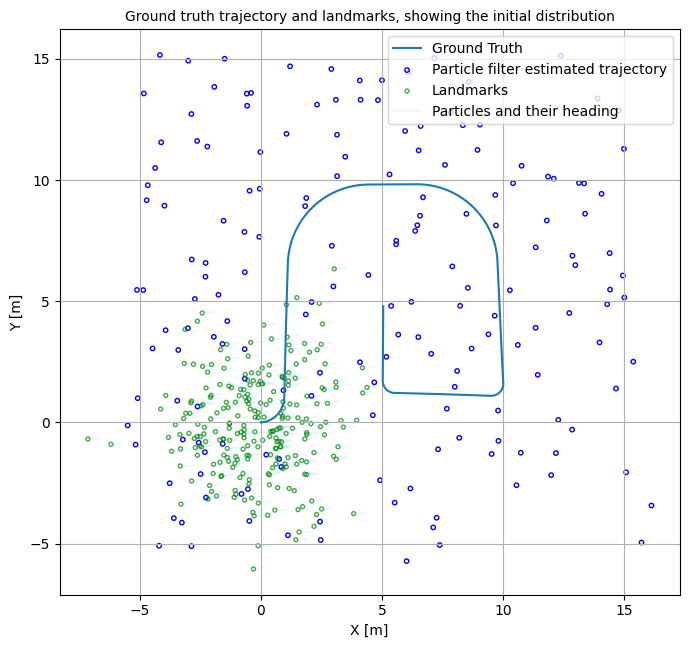

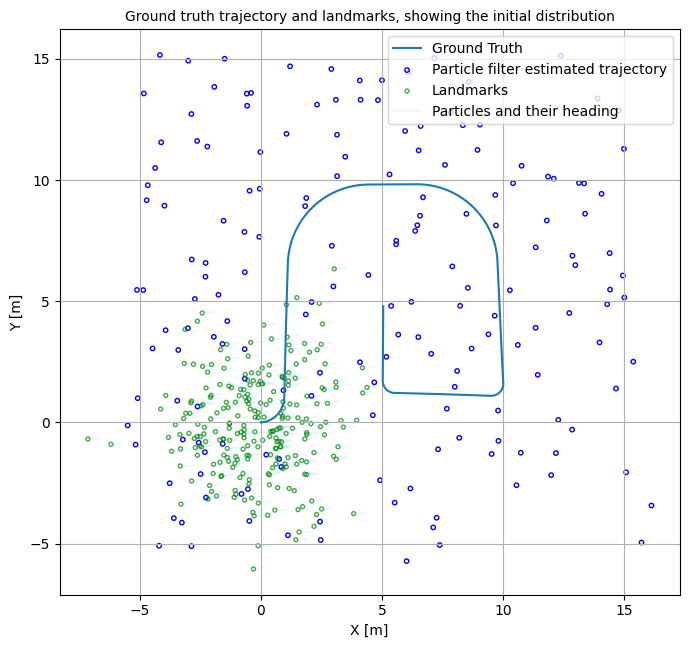

In [ ]:
sigma_range = 1# TODO
sigma_bearing = 0.1# TODO
num_particles=250# TODO
np.random.seed(seed_val)
print (f'trueLandmarks.shape = {trueLandmarks.shape}')
pf = ParticlesFilter(trueLandmarks, sigma_r1, sigma_t, sigma_r2, sigma_range, sigma_bearing,numberOfPaticles=num_particles)

# just to show the initial distribution of particles
draw_pf_frame(trueTrajectory, pf.history, trueLandmarks, pf.particles,"Ground truth trajectory and landmarks, showing the initial distribution")


## Run Particle Filter!

<ipython-input-46-ca49d30e8849>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 8))


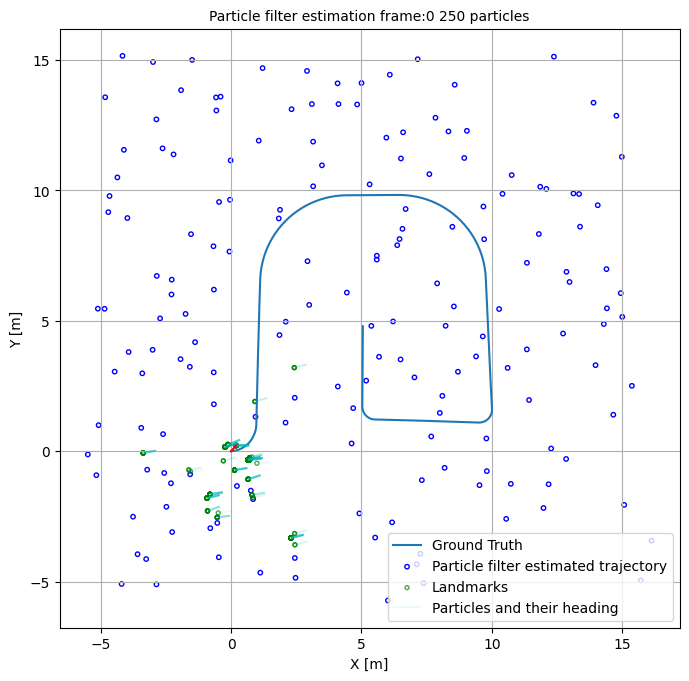

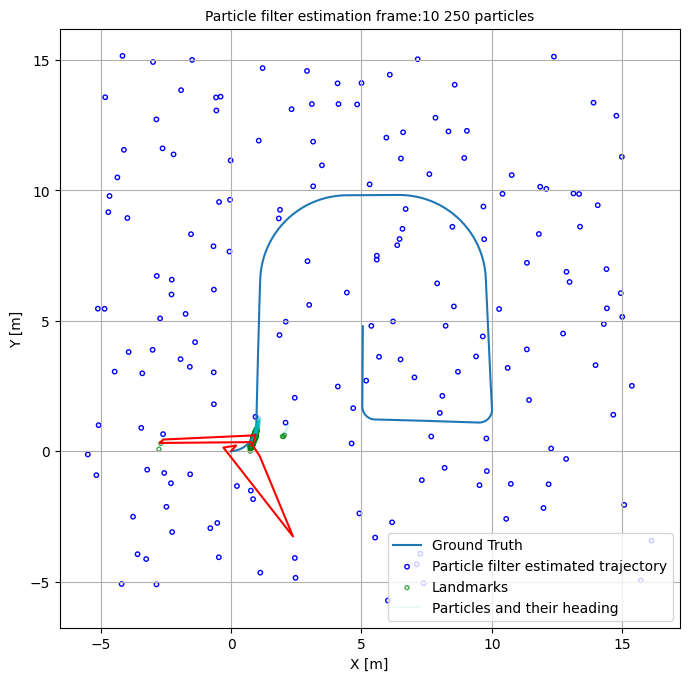

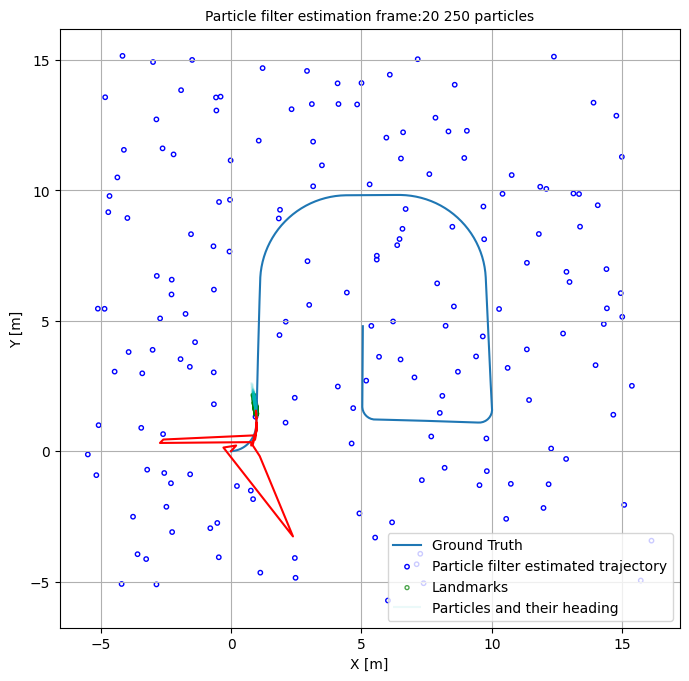

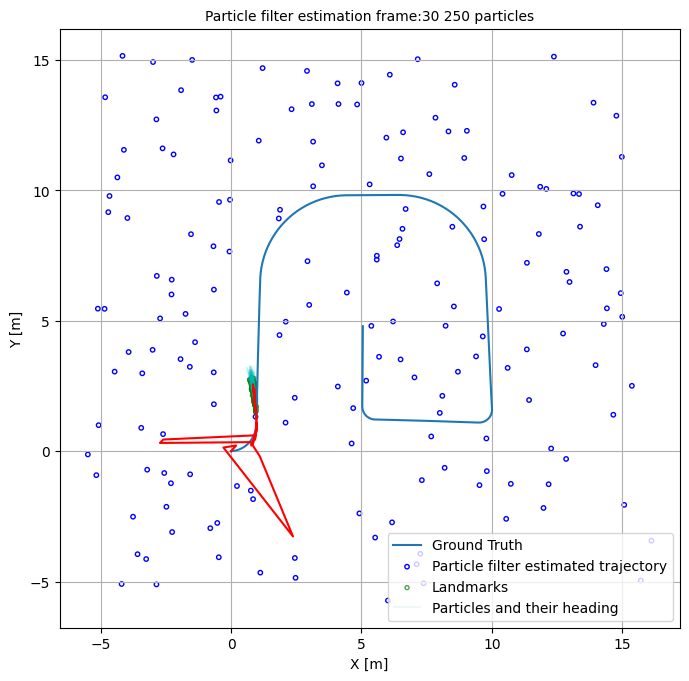

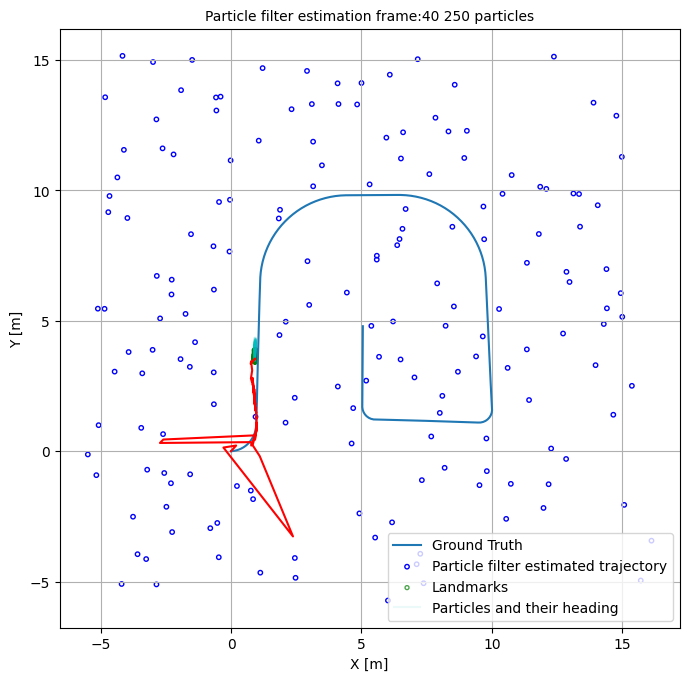

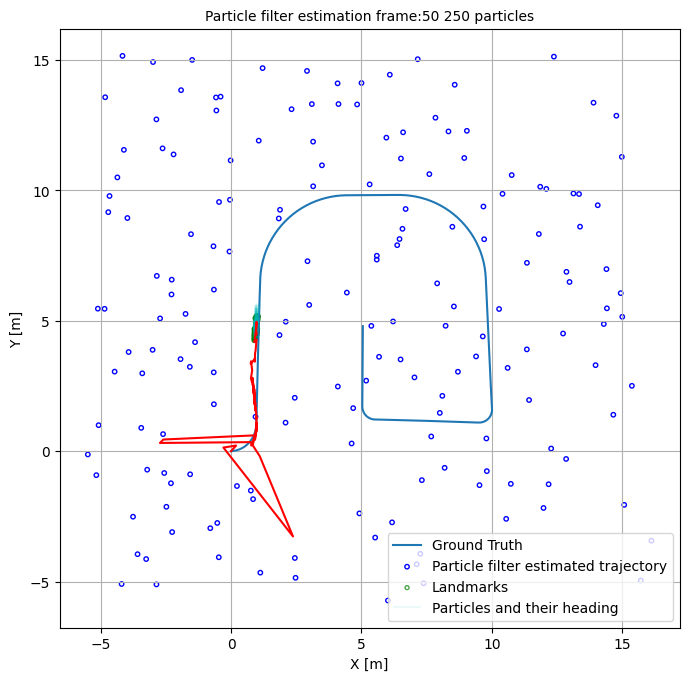

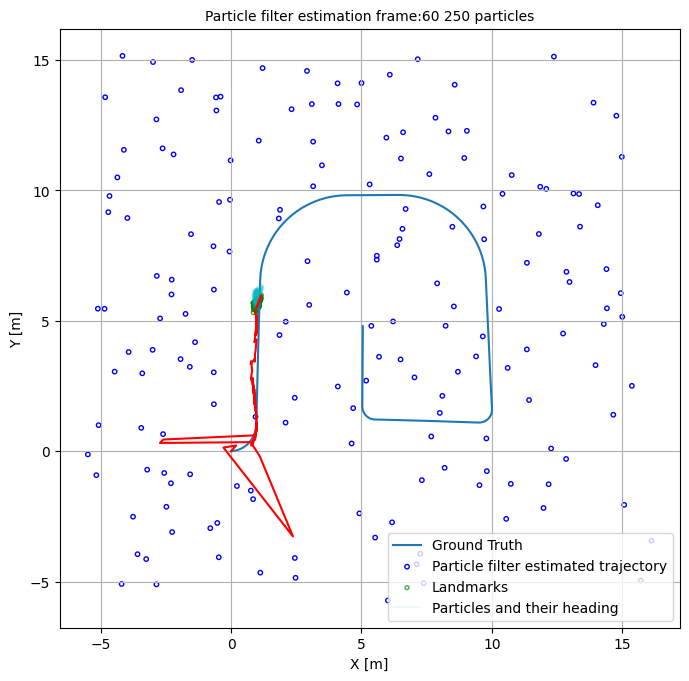

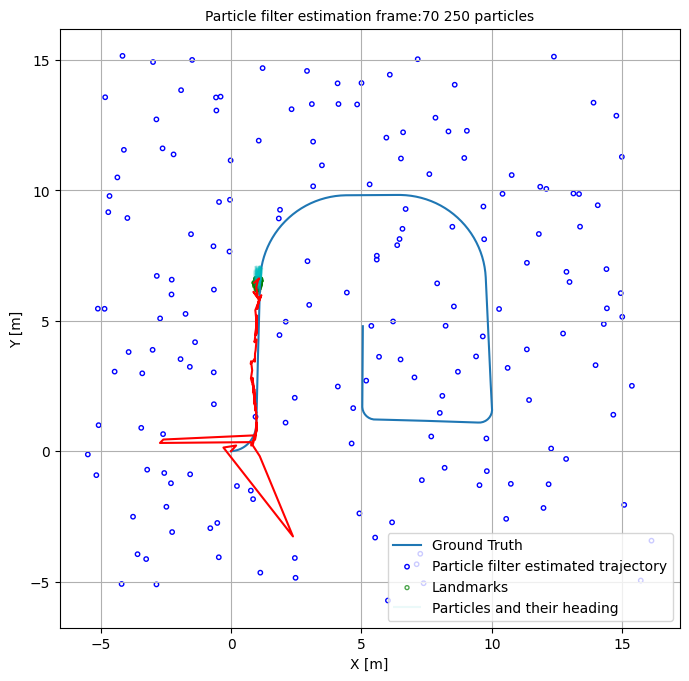

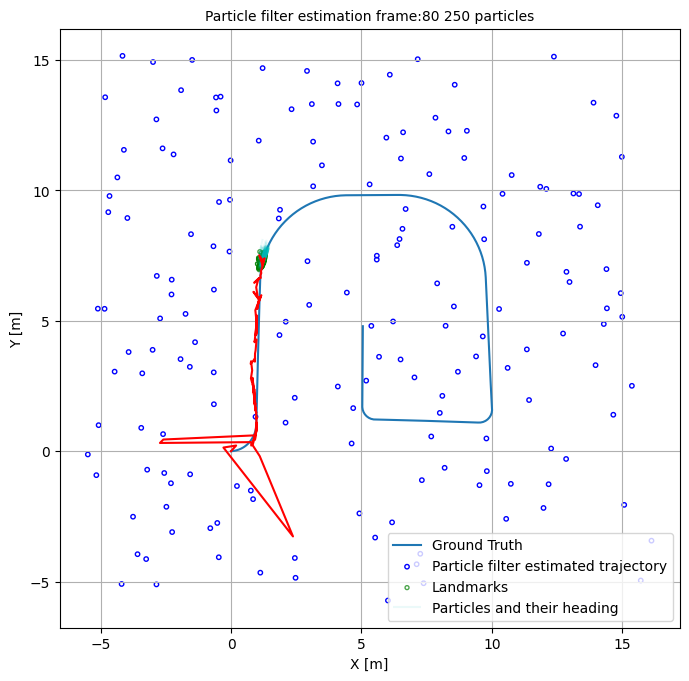

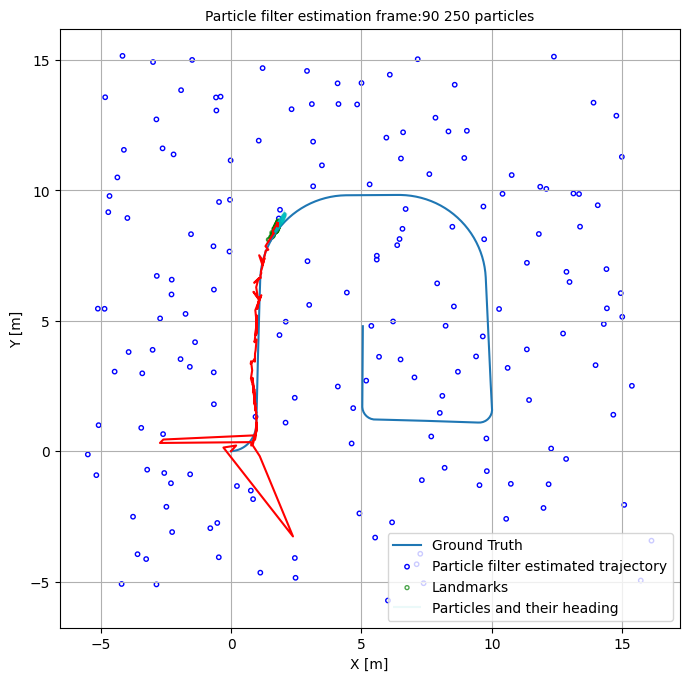

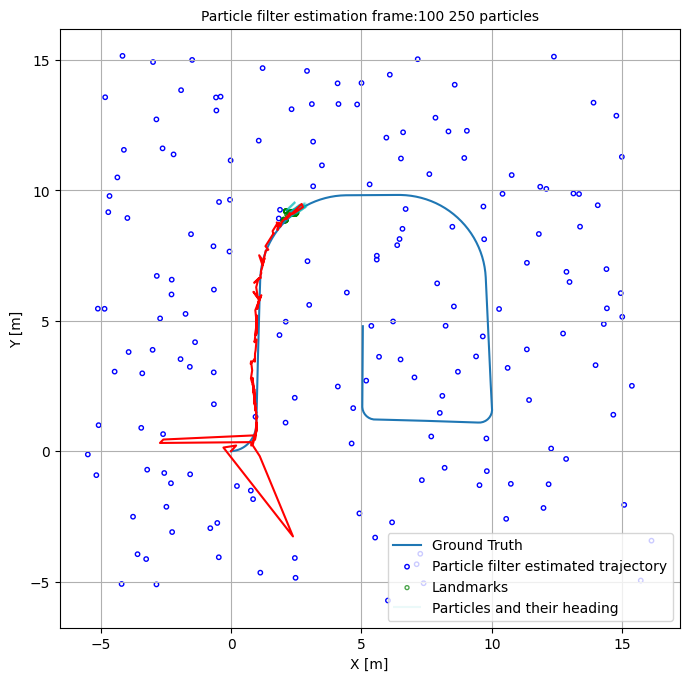

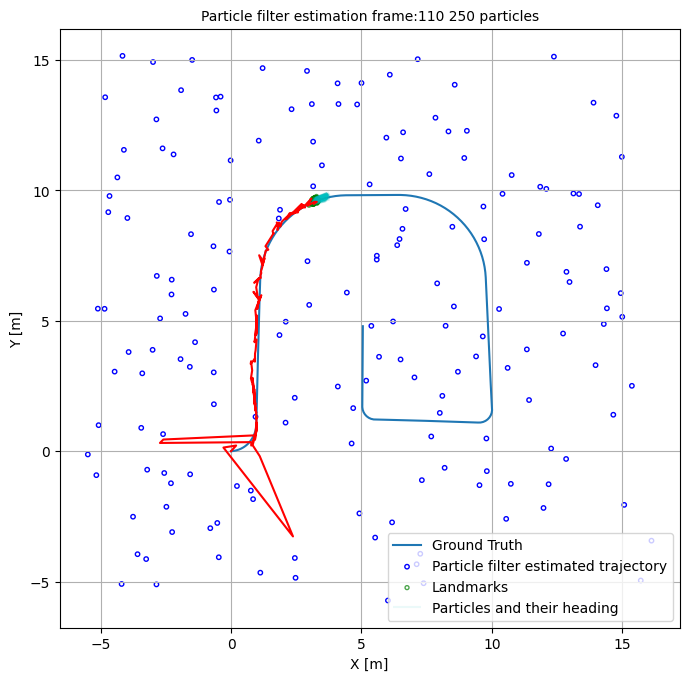

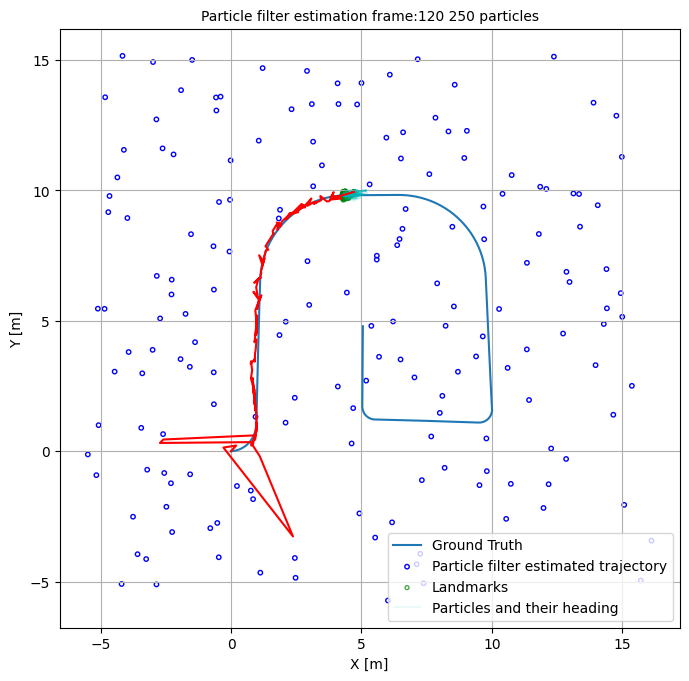

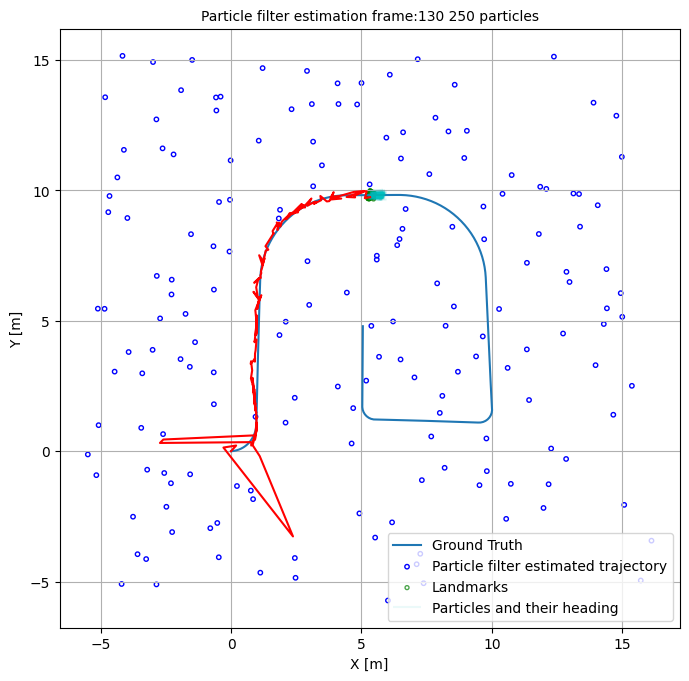

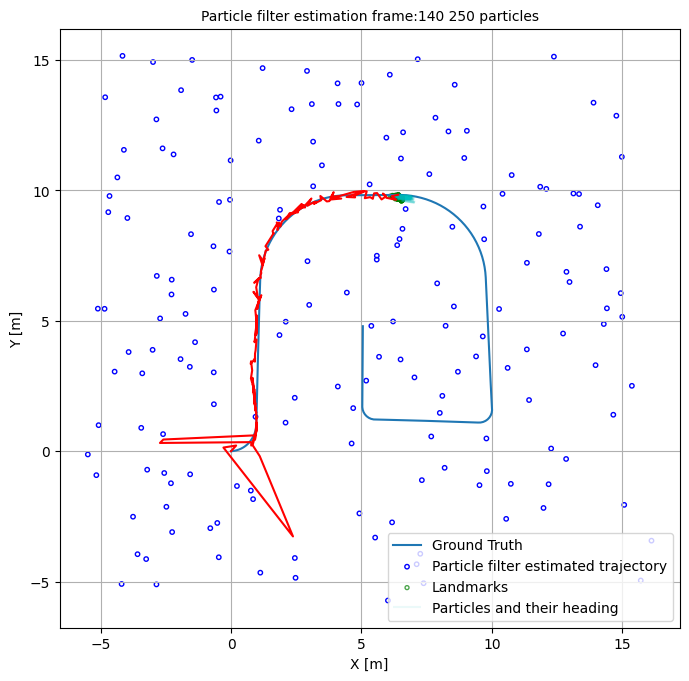

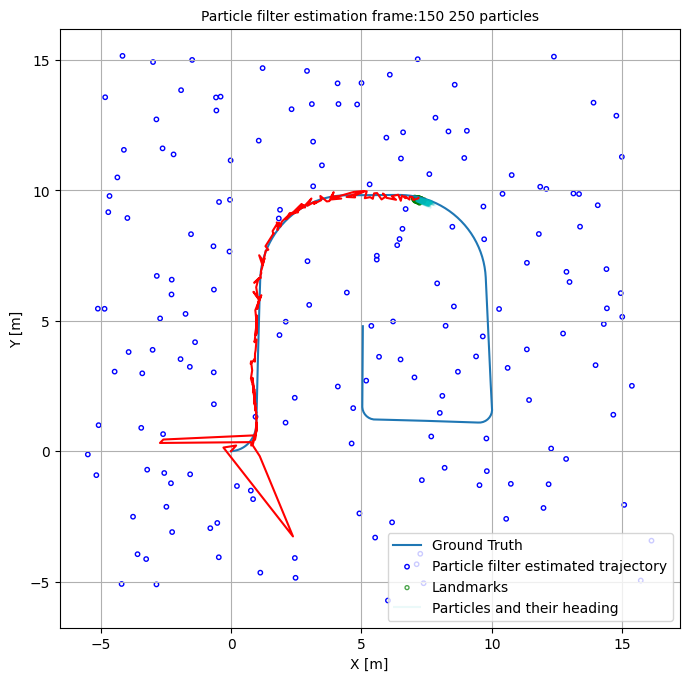

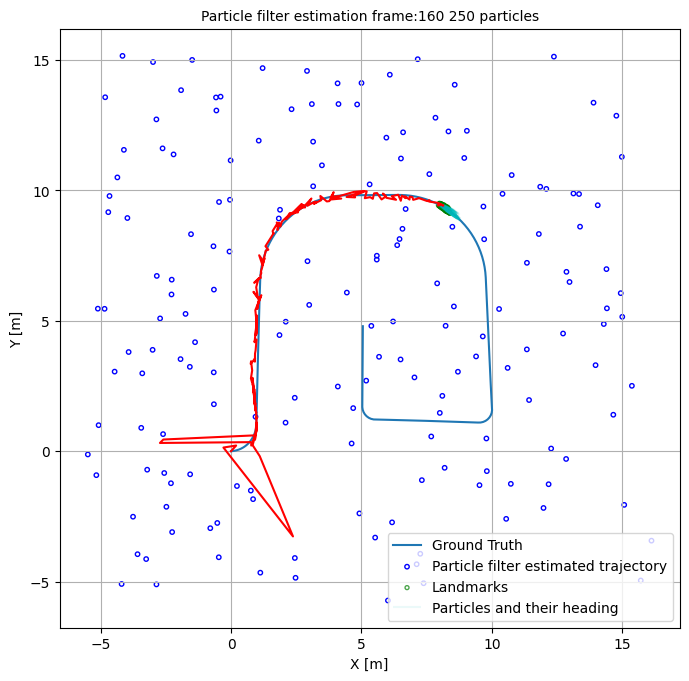

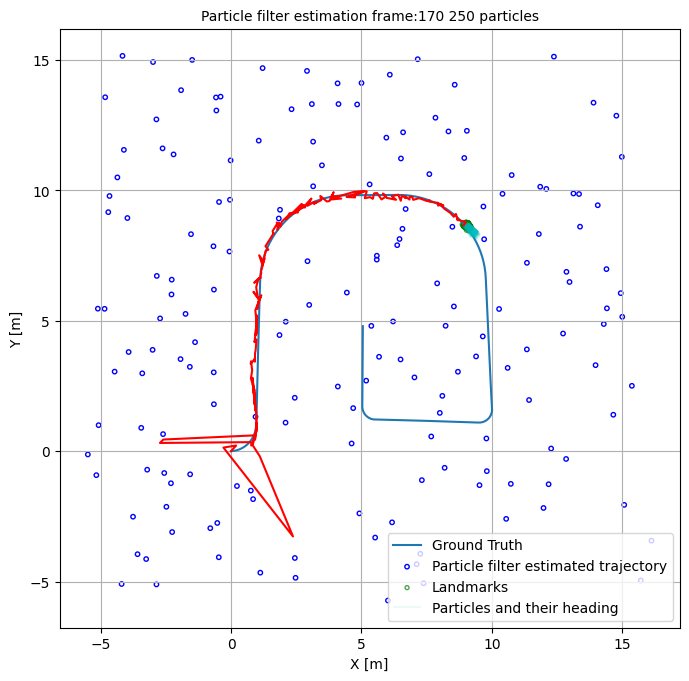

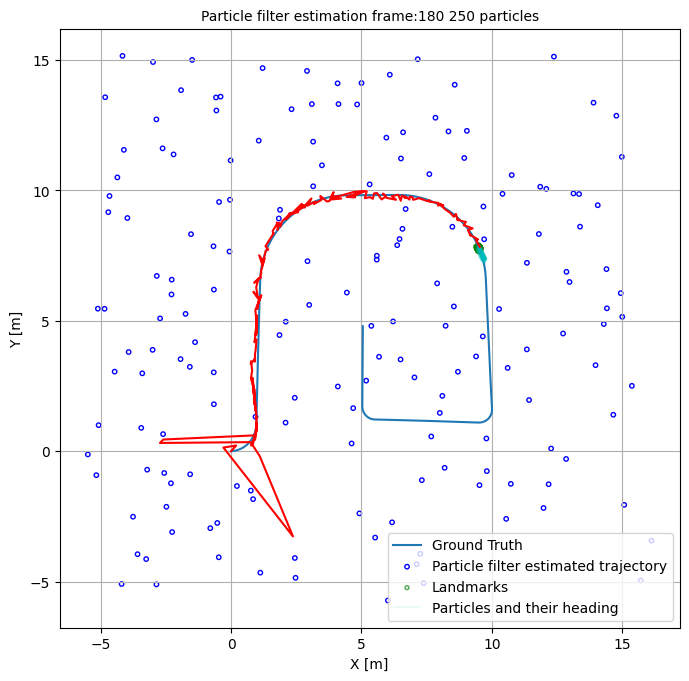

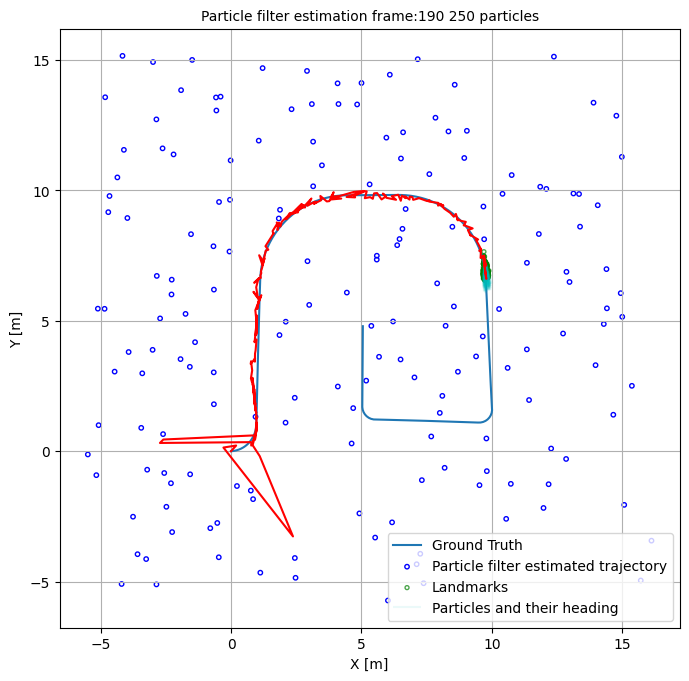

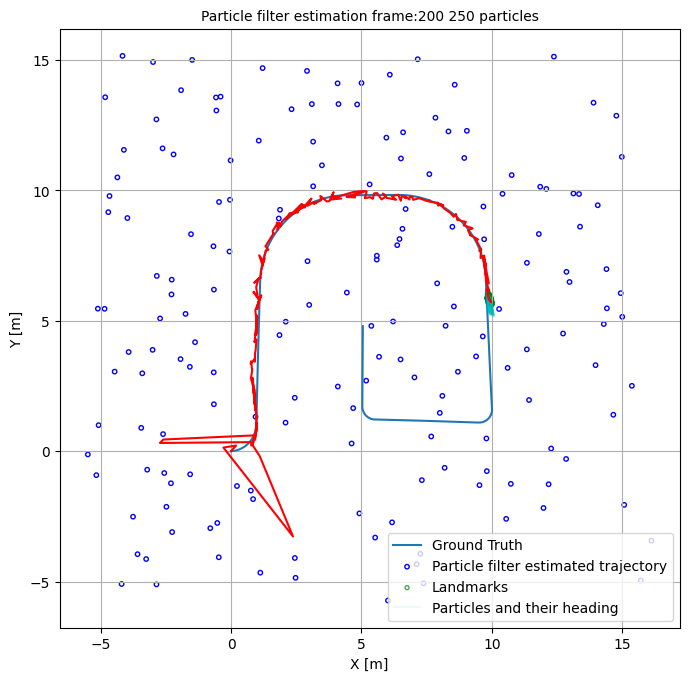

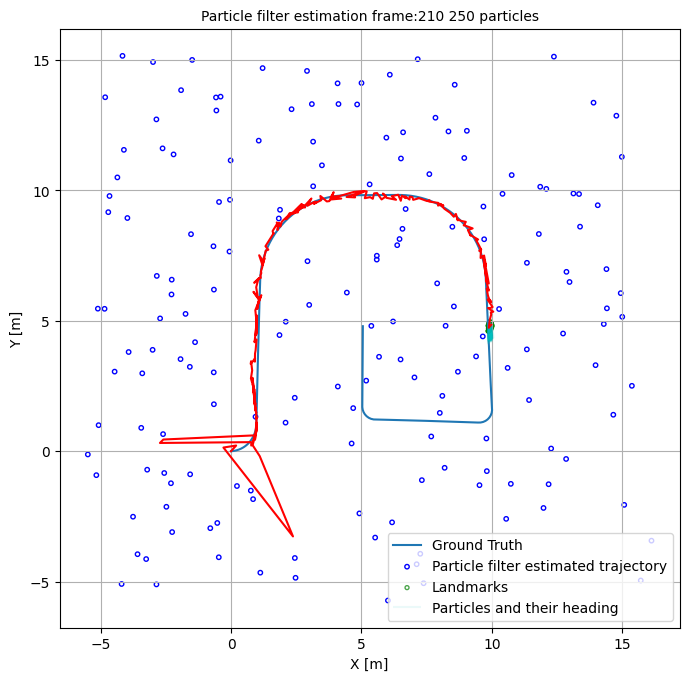

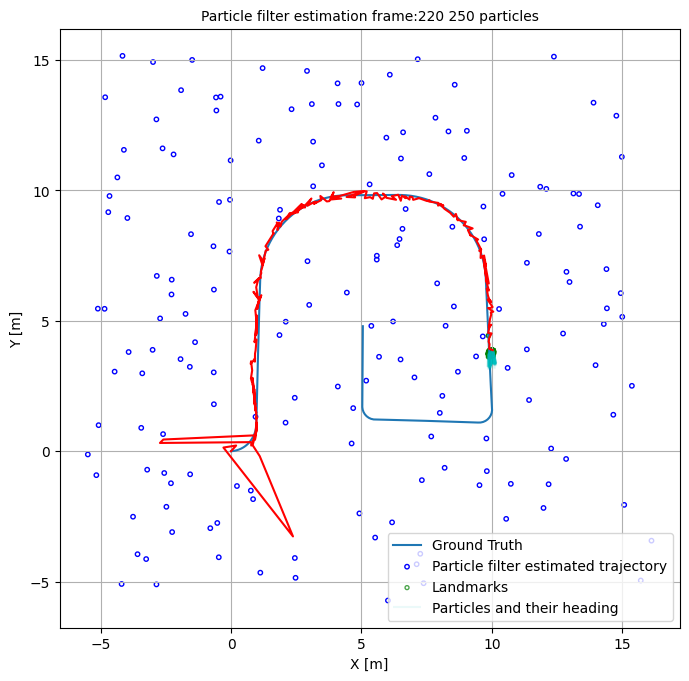

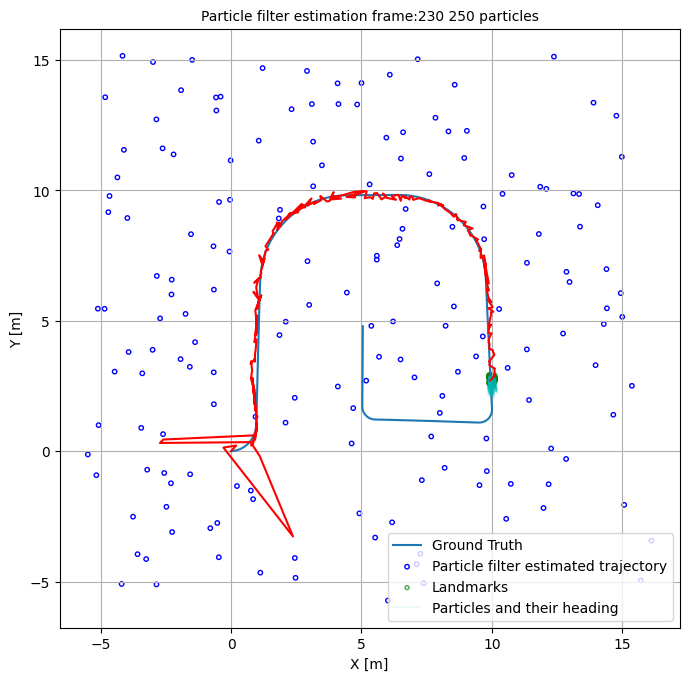

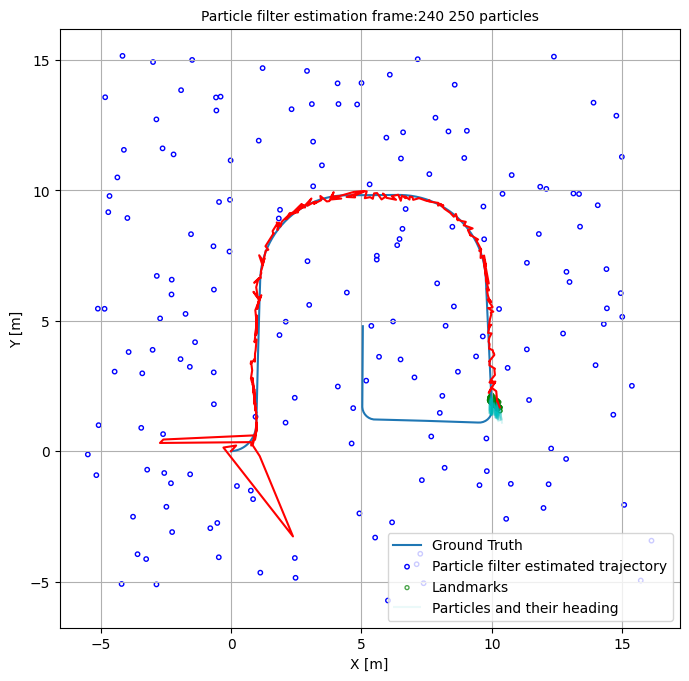

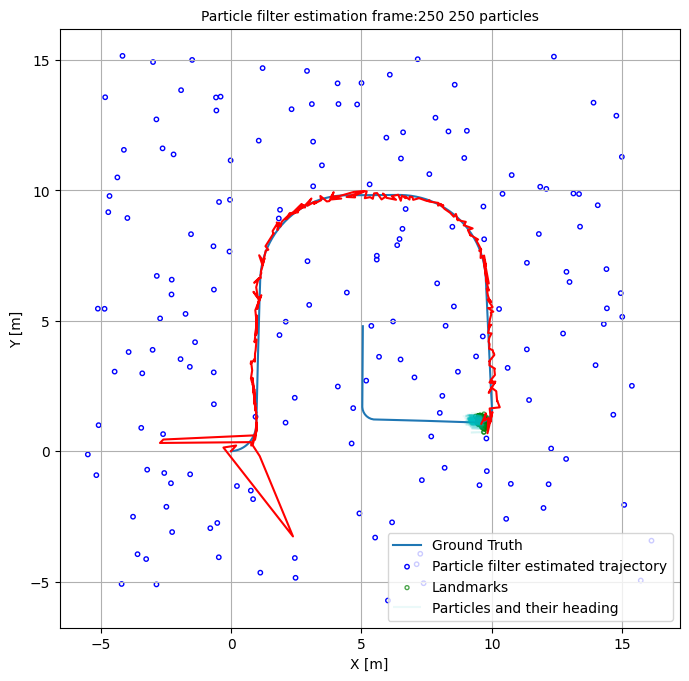

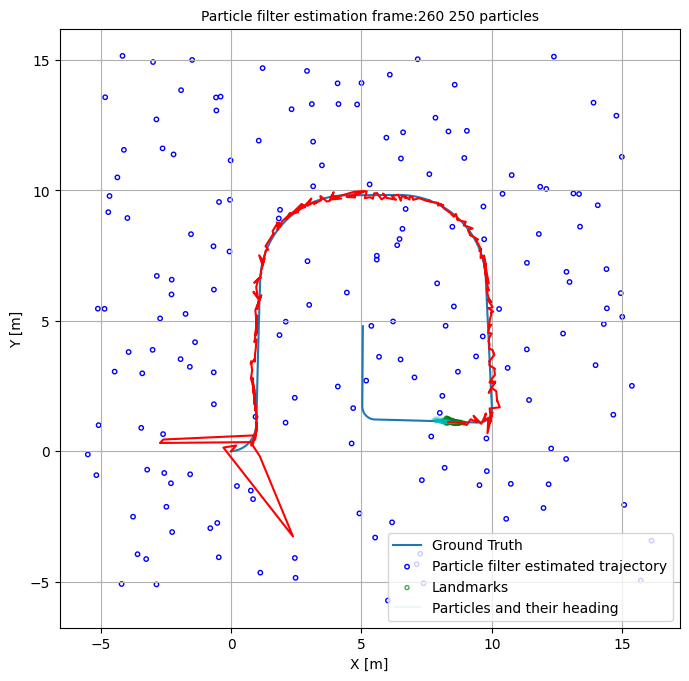

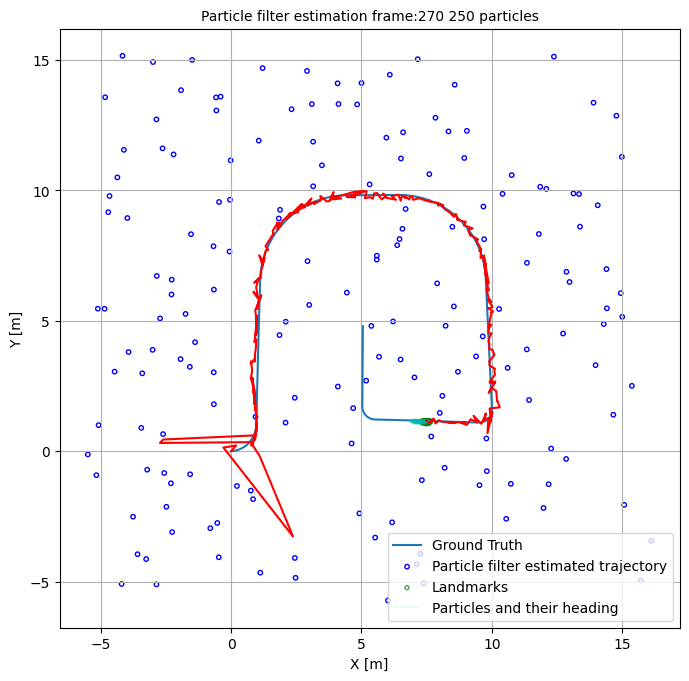

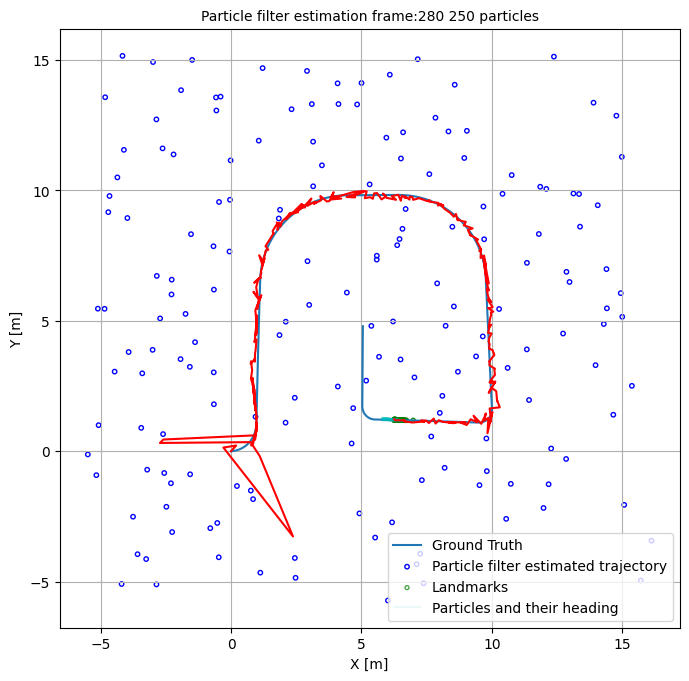

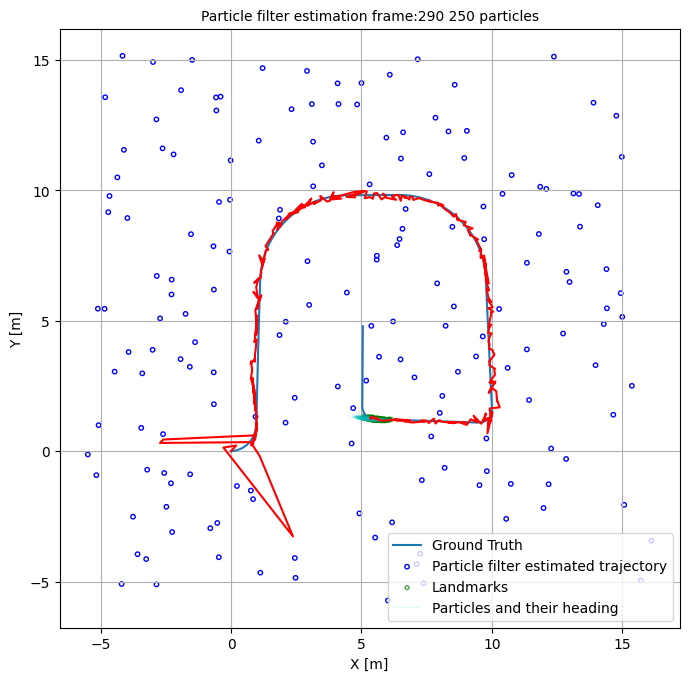

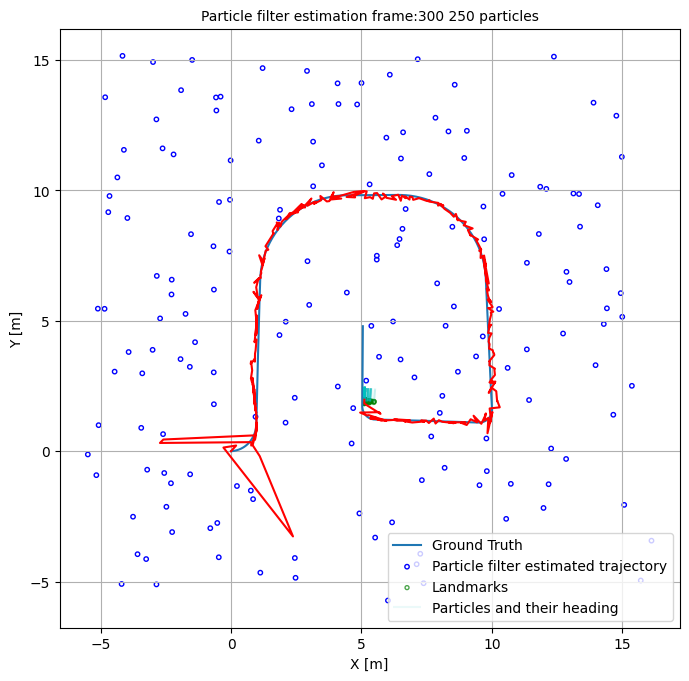

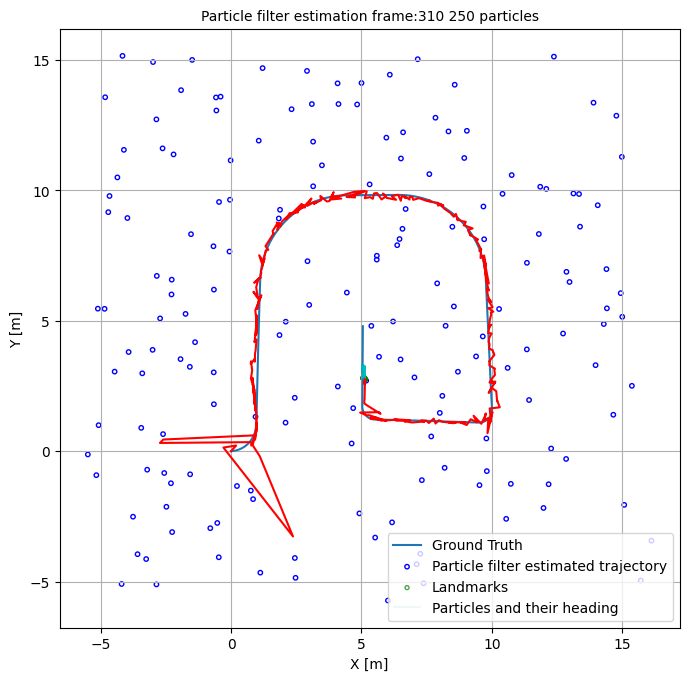

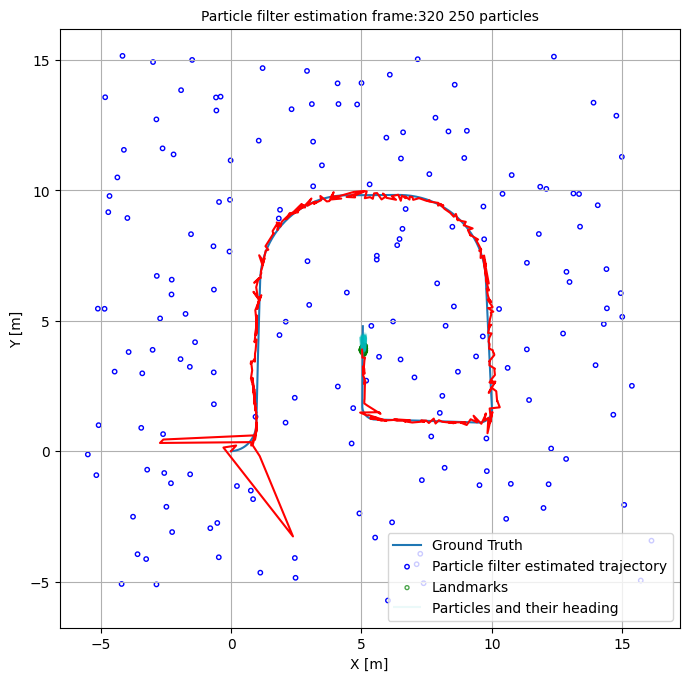

In [ ]:
import imageio
np.random.seed(seed_val)
frames = []
for i, timestamp in enumerate(range(0,trueOdometry.__len__() - 1)):

    # Observation model
    # calculate Zt - the range and bearing to the closest landmark as seen from the current true position of the robot
    closest_landmark_id = np.argmin(np.linalg.norm(trueLandmarks - trueTrajectory[i + 1, 0:2], axis=1, ord=1))# TODO (norma 1) hint (use, np.argmin,np.linalg.norm, trueLandmarks ,trueTrajectory[i + 1, 0:2])
    ClosetLandmarkLocation= trueLandmarks[closest_landmark_id]# TODO (hint use truelocation)
    dist_xy = trueLandmarks[closest_landmark_id] - trueTrajectory[i + 1, 0:2]
    r = np.linalg.norm(dist_xy, ord=1) # TODO (norma 1)
    phi = np.arctan2(dist_xy[1], dist_xy[0])  - trueTrajectory[i + 1, 2]# TODO
    r = r + np.random.normal(0,sigma_range)  # TODO (add noise)
    phi += np.random.normal(0,sigma_bearing)# TODO (add noise)
    phi = ParticlesFilter.normalize_angle(phi)# normalize (add noise)
    Zt = np.array([r, phi])

    pf.apply(Zt, trueOdometry[timestamp])
    if i % 10 == 0:
      title = "pf_estimation_frame:{}_{}_particles".format(i, num_particles)
      fig= draw_pf_frame(trueTrajectory, pf.history, trueLandmarks, pf.particles, title.replace("_", " ").replace("pf", "Particle filter"))
      canvas = fig.canvas
      canvas.draw()
      image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
      image = image.reshape(canvas.get_width_height()[::-1] + (3,))
      frames.append(image)
imageio.mimsave('/content/drive/MyDrive/Autonomous system/HW3/Results/Particle_filter.mp4',
                frames, format = 'mp4',
                fps = 10)




## Display last frame

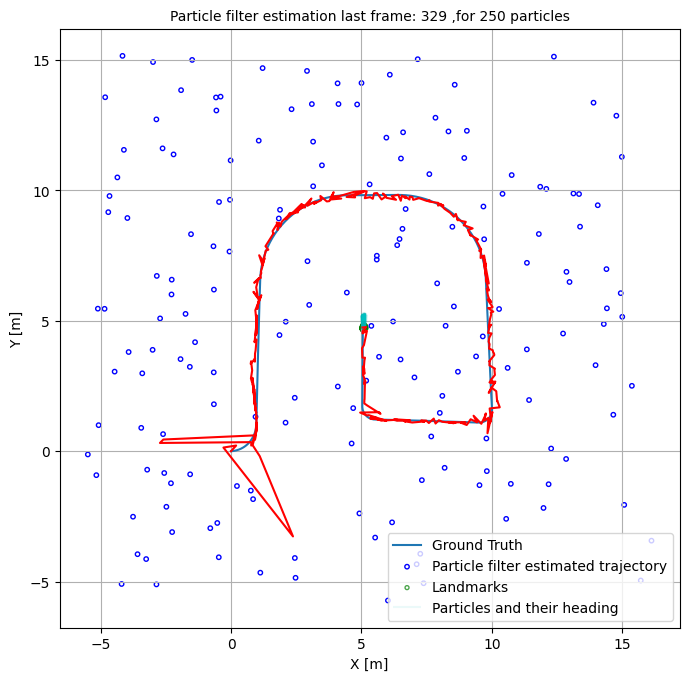

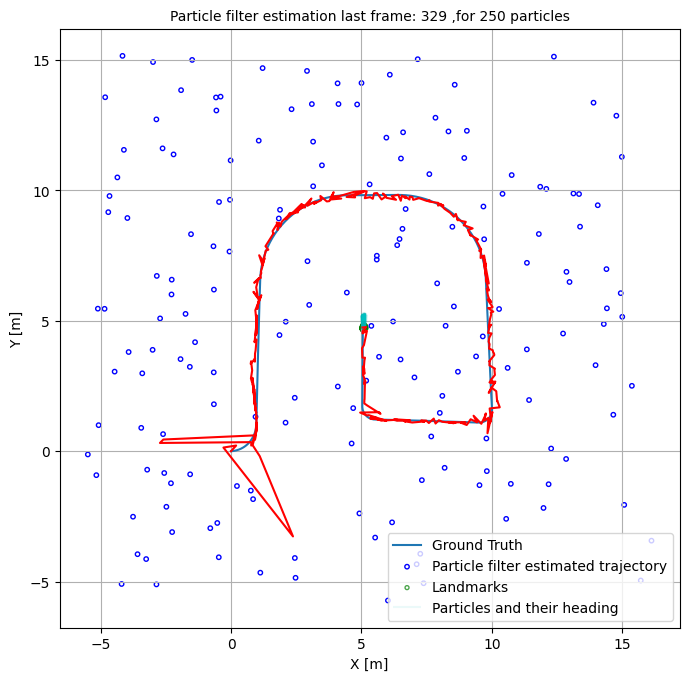

In [ ]:
title = "Particle filter estimation last frame: {} ,for {} particles".format(i, num_particles)
draw_pf_frame(trueTrajectory, pf.history, trueLandmarks, pf.particles,title)

# Analysis

## Display trajetories of GT, dead recokning and Particle filter results

Text(0.5, 1.0, 'Ground trues trajectory, landmarks and noisy trajectory')

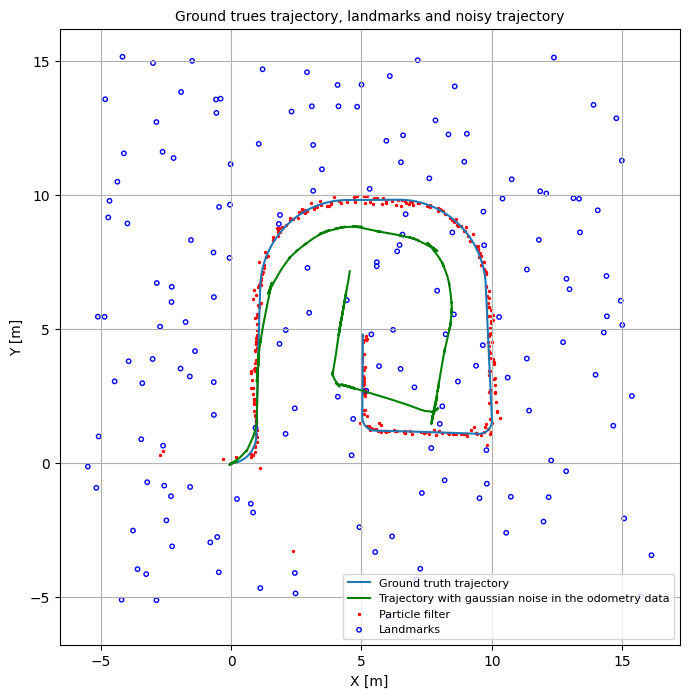

In [ ]:
    plt.figure(figsize=(8, 8))
    plt.plot(trueTrajectory[:, 0], trueTrajectory[:, 1])
    plt.plot(measured_trajectory[:, 0], measured_trajectory[:, 1], color='g')
    plt.scatter(pf.history[:, 0], pf.history[:, 1],s=2, color='r')
    plt.scatter(trueLandmarks[:, 0], trueLandmarks[:, 1], s=10, facecolors='none', edgecolors='b')
    plt.grid()
    plt.xlabel("X [m]", fontsize=10)
    plt.ylabel("Y [m]", fontsize=10)
    plt.legend(['Ground truth trajectory', 'Trajectory with gaussian noise in the odometry data','Particle filter', 'Landmarks'], prop={"size": 8}, loc="best")
    plt.title('Ground trues trajectory, landmarks and noisy trajectory', fontsize=10)

## Root Mean Square Error

In [ ]:
def calculate_mse(X_Y_GT, X_Y_est, start_frame=10):
    """
    calculate MSE

    Args:
        X_Y_GT (np.ndarray): ground truth values of x and y
        X_Y_est (np.ndarray): estimated values of x and y

    Returns:
        float: MSE
    """
   #TODO
    e_x = X_Y_GT[start_frame:,0] - X_Y_est[start_frame:,0]
    e_y = X_Y_GT[start_frame:,1] - X_Y_est[start_frame:,1]
    MSE = (sum(e_x**2+e_y**2))/(len(e_y))
    return float(MSE)

In [ ]:
start_frame_for_mse = 10
mse =calculate_mse(trueTrajectory, pf.history, start_frame_for_mse)
print("Mean Square error for {} particles is : {}".format(num_particles,mse))

Mean Square error for 250 particles is : 0.06089198194551752


# create a for loop to test best particale number

Mean Square error for 50 particles is : 29.48276826606631
Mean Square error for 100 particles is : 0.0457805553644285
Mean Square error for 200 particles is : 0.04374048930704859
Mean Square error for 300 particles is : 0.06036528900406764
Mean Square error for 400 particles is : 0.10675896462685823
Mean Square error for 500 particles is : 0.09062822480351253
Mean Square error for 600 particles is : 0.06624682312252735
Mean Square error for 700 particles is : 0.07760181376011774
Mean Square error for 800 particles is : 0.10823220571308459
Mean Square error for 900 particles is : 0.09193598848846955
Mean Square error for 1000 particles is : 1.6064962688478521
we get the best MSE of 0.04374048930704859 for num particals = 200


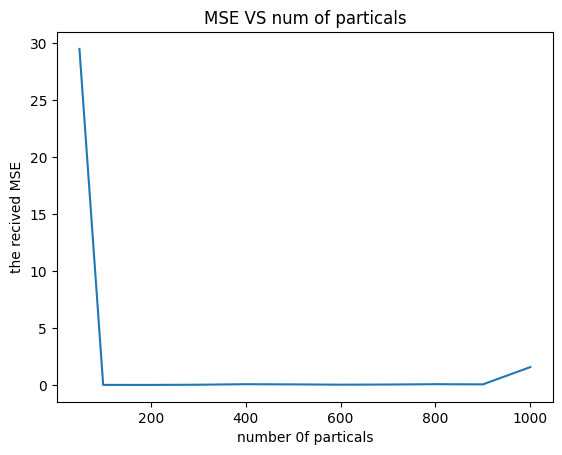

In [ ]:
np.random.seed(seed_val)
num_particals_options = [50,100,200,300,400,500,600,700,800,900,1000]
mse_arr=[]
min_error = np.inf
best_particals_number = -1
for num_particals in num_particals_options:
  pf = ParticlesFilter(trueLandmarks, sigma_r1, sigma_t, sigma_r2, sigma_range, sigma_bearing,numberOfPaticles=num_particals)
  for i, timestamp in enumerate(range(0,trueOdometry.__len__() - 1)):

    closest_landmark_id = np.argmin(np.linalg.norm(trueLandmarks - trueTrajectory[i + 1, 0:2], axis=1, ord=1))# TODO (norma 1) hint (use, np.argmin,np.linalg.norm, trueLandmarks ,trueTrajectory[i + 1, 0:2])
    ClosetLandmarkLocation= trueLandmarks[closest_landmark_id]# TODO (hint use truelocation)
    dist_xy = trueLandmarks[closest_landmark_id] - trueTrajectory[i + 1, 0:2]
    r = np.linalg.norm(dist_xy, ord=1) # TODO (norma 1)
    phi = np.arctan2(dist_xy[1], dist_xy[0])  - trueTrajectory[i + 1, 2]# TODO
    r = r + np.random.normal(0,sigma_range)  # TODO (add noise)
    phi += np.random.normal(0,sigma_bearing)# TODO (add noise)
    phi = ParticlesFilter.normalize_angle(phi)# normalize (add noise)
    Zt = np.array([r, phi])

    pf.apply(Zt, trueOdometry[timestamp])
  mse =calculate_mse(trueTrajectory, pf.history, start_frame_for_mse)
  mse_arr.append(mse)
  print("Mean Square error for {} particles is : {}".format(num_particals,mse))
  if mse <min_error:
    min_error = mse
    best_particals_number =num_particals
print(f'we get the best MSE of {min_error} for num particals = {best_particals_number}')

plt.plot(num_particals_options,mse_arr)
plt.xlabel('number 0f particals')
plt.ylabel('the recived MSE')
plt.title("MSE VS num of particals")
plt.show()